# 03 — Informed Incident Generator (Hotspot + Uniform Mix)

## Objective
Generate a synthetic emergency incident dataset for training and evaluation.

We will sample incident locations using:
- **Hotspot sampling** (empirical prior from Patel-based regions)
- **Uniform sampling** across Kigali (generalization)

We also assign:
- time-of-occurrence (minute index within a simulation horizon)
- a simple severity category

## Output (git-ignored)
- `data/processed/incidents/incidents_v1.csv`

## 1.0 Notebook Rules (Clean & Reproducible)

- **All imports live in the first code cell only**
- Reusable logic stays in `src/` modules and is imported here
- The notebook orchestrates generation, prints debug summaries, and creates plots
- Generation is **resume-safe**:
  - write incidents in chunks to CSV
  - if interrupted, resume from the last written incident_id

In [7]:
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox

# Make sure repo root is importable (so `src/...` imports work in notebooks)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.hotspots import load_hotspots, validate_hotspots, hotspots_to_dataframe
from src.sim.incident_generator import generate_incidents
from src.utils.io import get_last_incident_id, append_dataframe


# Paths
HOTSPOTS_PATH = PROJECT_ROOT / "configs" / "hotspots.json"
REGIONS_PATH = PROJECT_ROOT / "configs" / "hotspot_regions.json"

INC_DIR = PROJECT_ROOT / "data" / "processed" / "incidents"
INC_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = INC_DIR / "incidents_v1.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("HOTSPOTS_PATH:", HOTSPOTS_PATH)
print("REGIONS_PATH:", REGIONS_PATH)
print("OUT_CSV:", OUT_CSV)

PROJECT_ROOT: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems
HOTSPOTS_PATH: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/configs/hotspots.json
REGIONS_PATH: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/configs/hotspot_regions.json
OUT_CSV: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/data/processed/incidents/incidents_v1.csv


## 2.0 Load & Validate Configs

We load:
- `configs/hotspots.json` (15 discrete seed points with node_id/lat/lon)
- `configs/hotspot_regions.json` (macro regions + sampling policy)

We validate the hotspot config before generating any incidents.

In [2]:
# Load hotspots
hotspots_cfg = load_hotspots(HOTSPOTS_PATH)
errs = validate_hotspots(hotspots_cfg)

print("## Hotspot config validation")
if errs:
    print(f"[FAIL] Found {len(errs)} issue(s):")
    for e in errs:
        print(" -", e)
    raise RuntimeError("Fix configs/hotspots.json before generating incidents.")
else:
    print("[OK] hotspots.json is valid")

df_hotspots = hotspots_to_dataframe(hotspots_cfg)
cols = ["id", "name", "region_id", "node_id", "lat", "lon", "weight"]
print("\n## Hotspots preview")
display(df_hotspots[cols].head(15))

# Load regions + sampling policy
with open(REGIONS_PATH, "r", encoding="utf-8") as f:
    regions_cfg = json.load(f)

policy = regions_cfg.get("sampling_policy", {})
hotspot_fraction = float(policy.get("hotspot_fraction", 0.8))
uniform_fraction = float(policy.get("uniform_fraction", 0.2))

# Normalize if someone edits them badly later
total = hotspot_fraction + uniform_fraction
if total <= 0:
    hotspot_fraction, uniform_fraction = 0.8, 0.2
else:
    hotspot_fraction = hotspot_fraction / total
    uniform_fraction = uniform_fraction / total

print("\n## Sampling policy")
print("hotspot_fraction:", round(hotspot_fraction, 3))
print("uniform_fraction:", round(uniform_fraction, 3))

# Prepare hotspot list for generator (list of dicts)
hotspots_list = hotspots_cfg["hotspots"]

## Hotspot config validation
[OK] hotspots.json is valid

## Hotspots preview


,id,name,region_id,node_id,lat,lon,weight
0,HS01,R1_P1 — Central Kigali (CBD / Downtown),R1,279254284,-1.948202,30.057958,8.0
1,HS02,R1_P2 — Central Kigali (CBD / Downtown),R1,281375156,-1.950362,30.061309,8.0
2,HS03,R1_P3 — Central Kigali (CBD / Downtown),R1,279254295,-1.946908,30.058399,8.0
3,HS04,R1_P4 — Central Kigali (CBD / Downtown),R1,12237774265,-1.950586,30.055314,8.0
4,HS05,R1_P5 — Central Kigali (CBD / Downtown),R1,281375108,-1.948339,30.064269,8.0
5,HS06,R2_P1 — Nyabugogo (Transport hub area),R2,1223047162,-1.941434,30.050202,8.0
6,HS07,R2_P2 — Nyabugogo (Transport hub area),R2,1223047194,-1.942393,30.050042,8.0
7,HS08,R2_P3 — Nyabugogo (Transport hub area),R2,1223047118,-1.937843,30.053296,8.0
8,HS09,R2_P4 — Nyabugogo (Transport hub area),R2,1223047252,-1.938496,30.053403,8.0
9,HS10,R2_P5 — Nyabugogo (Transport hub area),R2,1223047198,-1.936985,30.053473,8.0



## Sampling policy
hotspot_fraction: 0.8
uniform_fraction: 0.2


## 3.0 Build City-wide Node Pool (Uniform Sampling)

To avoid overfitting to hotspots, we generate some incidents uniformly across Kigali.

We build a simple pool of candidate graph nodes from `kigali.graphml`.
Later, the incident generator will sample:
- `hotspot_fraction` from hotspot seed points (weighted)
- `uniform_fraction` from this city-wide node pool (uniform)

Note: We keep the node pool lightweight (node_id, lat, lon) for speed and reuse.

In [4]:
# Load Kigali graph and build a uniform node pool
GRAPHML_PATH = PROJECT_ROOT / "data" / "processed" / "network" / "kigali.graphml"
if not GRAPHML_PATH.exists():
    raise FileNotFoundError("Missing kigali.graphml. Run notebooks/01_osm_to_sumo.ipynb first.")

In [6]:
# Load Kigali graph and build a uniform node pool
GRAPHML_PATH = PROJECT_ROOT / "data" / "processed" / "network" / "kigali.graphml"
if not GRAPHML_PATH.exists():
    raise FileNotFoundError("Missing kigali.graphml. Run notebooks/01_osm_to_sumo.ipynb first.")

print("Loading graph:", GRAPHML_PATH)
G_city = ox.load_graphml(GRAPHML_PATH)
print("Graph loaded. Nodes:", len(G_city.nodes), "Edges:", len(G_city.edges))

gdf_nodes = ox.graph_to_gdfs(G_city, nodes=True, edges=False).reset_index().rename(columns={"osmid": "node_id"})
gdf_nodes["lat"] = gdf_nodes["y"]
gdf_nodes["lon"] = gdf_nodes["x"]

# Optional downsample for speed (keep reproducible)
MAX_UNIFORM_NODES = 20000
if len(gdf_nodes) > MAX_UNIFORM_NODES:
    gdf_nodes = gdf_nodes.sample(n=MAX_UNIFORM_NODES, random_state=42).reset_index(drop=True)

print("Uniform node pool size:", len(gdf_nodes))
display(gdf_nodes[["node_id", "lat", "lon"]].head(10))

# Build uniform node list for generator
all_nodes_list = []
for row in gdf_nodes.itertuples(index=False):
    all_nodes_list.append(
        {
            "id": None,
            "region_id": None,
            "node_id": int(row.node_id),
            "lat": float(row.lat),
            "lon": float(row.lon),
            "weight": 1.0,
        }
    )

print("[OK] all_nodes_list ready:", len(all_nodes_list))

# Generation constants
HORIZON_MIN = 24 * 60
N_TOTAL = 10_000
CHUNK_SIZE = 1_000

print("\n## Generation parameters")
print("HORIZON_MIN:", HORIZON_MIN)
print("N_TOTAL:", N_TOTAL)
print("CHUNK_SIZE:", CHUNK_SIZE)

Loading graph: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/data/processed/network/kigali.graphml
Graph loaded. Nodes: 18941 Edges: 50228
Uniform node pool size: 18941


,node_id,lat,lon
0,279244409,-1.953869,30.086600
1,279244410,-1.953824,30.085752
2,279244419,-1.956300,30.085398
3,279244423,-1.958525,30.084299
4,279244424,-1.957775,30.084640
5,279244427,-1.959923,30.083587
6,279244715,-1.957120,30.080845
7,279244723,-1.955625,30.080088
8,279244751,-1.954700,30.077492
9,279244753,-1.955560,30.074841


[OK] all_nodes_list ready: 18941

## Generation parameters
HORIZON_MIN: 1440
N_TOTAL: 10000
CHUNK_SIZE: 1000


## 4.0 Generate Incidents (Resume-safe)

This step writes `N_TOTAL` incidents to `OUT_CSV` in chunks.

Resume behavior:
- If `OUT_CSV` already exists, we read the last `incident_id`
- We continue generating from the next id until `N_TOTAL` is reached
- This avoids restarting from scratch if the notebook/kernel stops

We log progress after each chunk.

In [8]:
print("## Resume-safe incident generation")
last_id = get_last_incident_id(OUT_CSV)
print("OUT_CSV exists:", OUT_CSV.exists())
print("Last incident_id:", last_id)

remaining = N_TOTAL - last_id
if remaining <= 0:
    print("[OK] Nothing to do. CSV already has N_TOTAL incidents.")
else:
    print("Remaining incidents to generate:", remaining)

    # We generate chunk by chunk and append to CSV.
    # Note: We pass a seed per chunk so generation is reproducible chunk-wise.
    start_id = last_id + 1
    next_id = start_id

    while next_id <= N_TOTAL:
        chunk_n = min(CHUNK_SIZE, N_TOTAL - next_id + 1)

        # Seed derived from chunk start for stable chunk reproducibility
        chunk_seed = 42 + next_id

        incidents = generate_incidents(
            n=chunk_n,
            hotspots=hotspots_list,
            all_nodes=all_nodes_list,
            horizon_min=HORIZON_MIN,
            seed=chunk_seed,
            hotspot_fraction=hotspot_fraction,
        )

        # Convert to DataFrame
        df_chunk = pd.DataFrame([i.__dict__ for i in incidents])

        # Adjust incident_id to continue sequence correctly
        df_chunk["incident_id"] = range(next_id, next_id + chunk_n)

        append_dataframe(OUT_CSV, df_chunk)

        print(f"[WROTE] {chunk_n} rows | incident_id {next_id}..{next_id + chunk_n - 1}")
        next_id += chunk_n

# Quick verification read
df_all = pd.read_csv(OUT_CSV)
print("\n## CSV summary")
print("Rows:", len(df_all))
print("Columns:", list(df_all.columns))

print("\n## Location type counts")
print("hotspot_id null (uniform):", int(df_all["hotspot_id"].isna().sum()))
print("hotspot_id not null (hotspot):", int(df_all["hotspot_id"].notna().sum()))

print("\n## Severity counts")
print(df_all["severity"].value_counts())

## Resume-safe incident generation
OUT_CSV exists: False
Last incident_id: 0
Remaining incidents to generate: 10000
[WROTE] 1000 rows | incident_id 1..1000
[WROTE] 1000 rows | incident_id 1001..2000
[WROTE] 1000 rows | incident_id 2001..3000
[WROTE] 1000 rows | incident_id 3001..4000
[WROTE] 1000 rows | incident_id 4001..5000
[WROTE] 1000 rows | incident_id 5001..6000
[WROTE] 1000 rows | incident_id 6001..7000
[WROTE] 1000 rows | incident_id 7001..8000
[WROTE] 1000 rows | incident_id 8001..9000
[WROTE] 1000 rows | incident_id 9001..10000

## CSV summary
Rows: 10000
Columns: ['incident_id', 'ts_min', 'hotspot_id', 'region_id', 'node_id', 'lat', 'lon', 'severity']

## Location type counts
hotspot_id null (uniform): 2063
hotspot_id not null (hotspot): 7937

## Severity counts
severity
low       6052
medium    2942
high      1006
Name: count, dtype: int64


## 5.0 Sanity Visualizations

We produce quick plots to confirm the generated dataset looks reasonable:
- time-of-day distribution (`ts_min`)
- hotspot vs uniform mix
- severity distribution

We also save figures to `reports/figures/` for reuse in the report.

Saving figures to: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/reports/figures


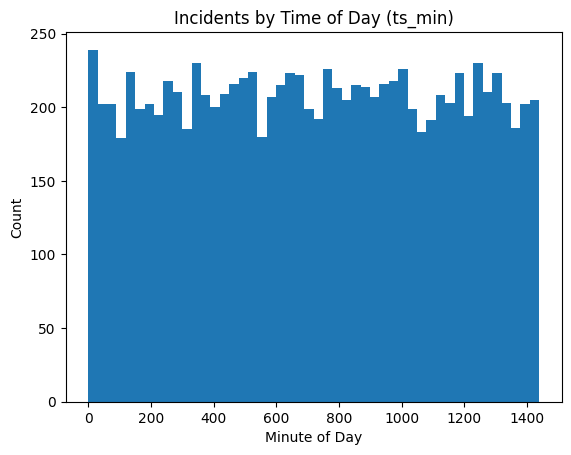

[OK] Saved: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/reports/figures/incidents_time_of_day.png


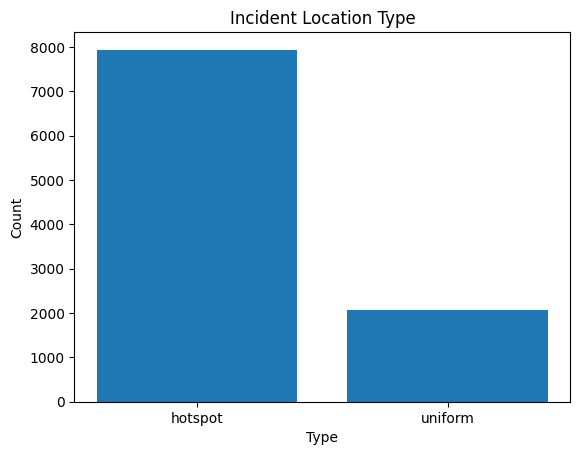

[OK] Saved: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/reports/figures/incidents_hotspot_vs_uniform.png


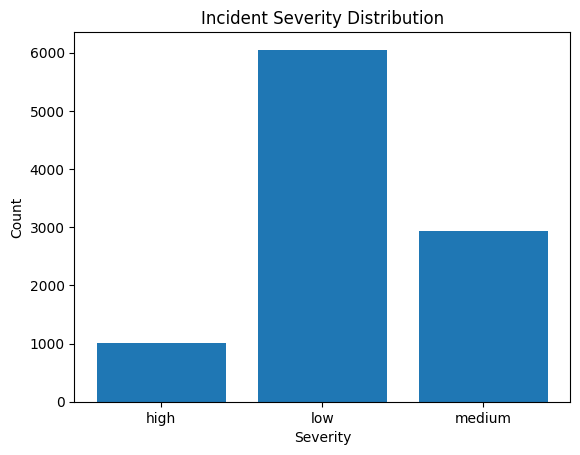

[OK] Saved: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/reports/figures/incidents_severity.png


In [9]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Saving figures to:", FIG_DIR)

# 1) Time-of-day distribution
plt.figure()
plt.hist(df_all["ts_min"], bins=48)  # 30-min bins across 24h
plt.title("Incidents by Time of Day (ts_min)")
plt.xlabel("Minute of Day")
plt.ylabel("Count")
out1 = FIG_DIR / "incidents_time_of_day.png"
plt.savefig(out1, dpi=150, bbox_inches="tight")
plt.show()
print("[OK] Saved:", out1)

# 2) Hotspot vs uniform mix
plt.figure()
counts = [int(df_all["hotspot_id"].notna().sum()), int(df_all["hotspot_id"].isna().sum())]
labels = ["hotspot", "uniform"]
plt.bar(labels, counts)
plt.title("Incident Location Type")
plt.xlabel("Type")
plt.ylabel("Count")
out2 = FIG_DIR / "incidents_hotspot_vs_uniform.png"
plt.savefig(out2, dpi=150, bbox_inches="tight")
plt.show()
print("[OK] Saved:", out2)

# 3) Severity distribution
plt.figure()
sev_counts = df_all["severity"].value_counts().sort_index()
plt.bar(sev_counts.index.astype(str), sev_counts.values)
plt.title("Incident Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
out3 = FIG_DIR / "incidents_severity.png"
plt.savefig(out3, dpi=150, bbox_inches="tight")
plt.show()
print("[OK] Saved:", out3)

In [10]:
df_all["hour"] = df_all["ts_min"] / 60.0
df_all["ts_str"] = df_all["ts_min"].apply(lambda m: f"{int(m//60):02d}:{int(m%60):02d}")

print("## Time preview")
display(df_all[["incident_id", "ts_min", "ts_str", "hour", "severity"]].head(10))

## Time preview


,incident_id,ts_min,ts_str,hour,severity
0,1,831,13:51,13.850000,medium
1,2,28,00:28,0.466667,medium
2,3,920,15:20,15.333333,high
3,4,272,04:32,4.533333,low
4,5,401,06:41,6.683333,low
5,6,1207,20:07,20.116667,low
6,7,1425,23:45,23.750000,high
7,8,67,01:07,1.116667,low
8,9,48,00:48,0.800000,low
9,10,868,14:28,14.466667,low


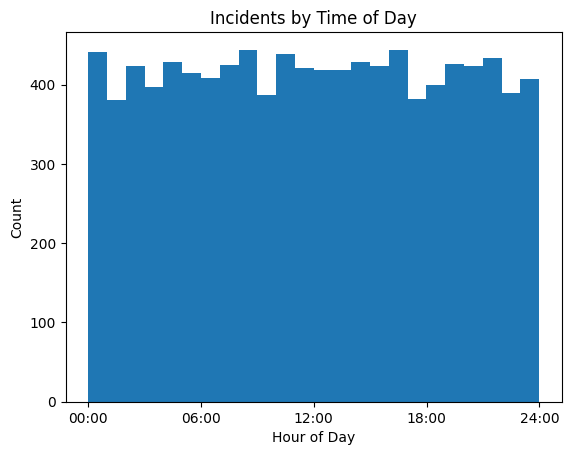

[OK] Saved: /Users/testsolutions/Documents/Academics/mission-capstone/marl-in-ems/reports/figures/incidents_time_of_day.png


In [11]:
plt.figure()
plt.hist(df_all["hour"], bins=24)  # 1-hour bins
plt.title("Incidents by Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks([0, 6, 12, 18, 24], ["00:00", "06:00", "12:00", "18:00", "24:00"])
out1 = FIG_DIR / "incidents_time_of_day.png"
plt.savefig(out1, dpi=150, bbox_inches="tight")
plt.show()
print("[OK] Saved:", out1)